### Task Details

*Come up with a GENERAL learning rate decay strategy for deep learning* 

It will be based off of the last script of *cats and dogs*. A good final report will document the approach, the experimentation and the blog post/notebook. 

Reference Link
http://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/

In [1]:
import keras
from keras import backend as K
from keras.datasets import cifar10

#----------------------------------------------------------

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import LearningRateScheduler

#----------------------------------------------------------

import math
import warnings
import numpy as np

#----------------------------------------------------------

from skimage.io import imread
from skimage import exposure, color
from skimage import data, img_as_float

#----------------------------------------------------------

import matplotlib
%matplotlib inline  
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Load Data - CIFAR 

In [2]:
# Initialize Training Parameters
epochs = 10
num_classes = 2
batch_size = 64

# input image dimensions
img_rows, img_cols = 32, 32   

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()   

# Only look at cats [=3] and dogs [=5]
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     

# Initialize training and test data corresponding to 3s and 5s
y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

### Preprocess - Image Samples

In [3]:
# Convert test and training data to Tensor

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
  

In [4]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)

In [5]:
# Normalize test and training data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [6]:
# Display Train and Test Sample Count
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples


### Define - ConvNet Architecture

In [7]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

### Function - Compute Decaying Learning Rate

In [8]:
decay_rate = []

drop = 0.5
epochs_drop = 1.0
initial_lrate = 0.1

def step_decay(epoch):
    
    # LearningRate = InitialLearningRate * DropRate^floor(Epoch / EpochDrop)
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    # Store the decaying learning rate in a list
    decay_rate.append(lrate)
    
    return lrate 

### Initialize - Tratinng Parameters

In [9]:
# Initialize Learning Rate Scheduler Callback
lrate = LearningRateScheduler(step_decay)

# Initialize CNN Model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### Train Model

In [10]:
print("Run Regular Training")
history = model.fit(x_train, y_train,                
                verbose=2,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, y_test),
                callbacks=[lrate])

Run Regular Training
Train on 10000 samples, validate on 2000 samples
Epoch 1/10
8s - loss: 0.7222 - acc: 0.5041 - val_loss: 0.6910 - val_acc: 0.5280
Epoch 2/10
8s - loss: 0.7014 - acc: 0.5110 - val_loss: 0.6921 - val_acc: 0.5235
Epoch 3/10
8s - loss: 0.7011 - acc: 0.5102 - val_loss: 0.6922 - val_acc: 0.5230
Epoch 4/10
9s - loss: 0.7001 - acc: 0.5051 - val_loss: 0.6922 - val_acc: 0.5235
Epoch 5/10
8s - loss: 0.6990 - acc: 0.5053 - val_loss: 0.6922 - val_acc: 0.5260
Epoch 6/10
8s - loss: 0.6978 - acc: 0.5188 - val_loss: 0.6921 - val_acc: 0.5255
Epoch 7/10
8s - loss: 0.6966 - acc: 0.5160 - val_loss: 0.6921 - val_acc: 0.5245
Epoch 8/10
8s - loss: 0.6969 - acc: 0.5137 - val_loss: 0.6921 - val_acc: 0.5250
Epoch 9/10
8s - loss: 0.6977 - acc: 0.5102 - val_loss: 0.6921 - val_acc: 0.5245
Epoch 10/10
8s - loss: 0.6975 - acc: 0.5100 - val_loss: 0.6921 - val_acc: 0.5250


### Visualize - Accuracy vs Epochs

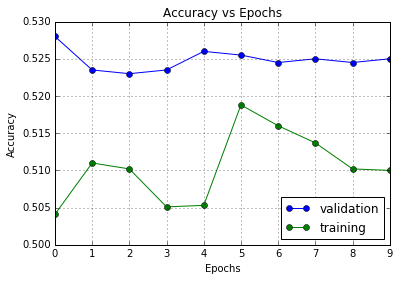

In [11]:
plt.plot(history.epoch,history.history['val_acc'], '-o', label='validation')
plt.plot(history.epoch,history.history['acc'], '-o', label='training')

plt.grid(True)
plt.legend(loc=0)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')

### Visualize - Loss vs Epochs

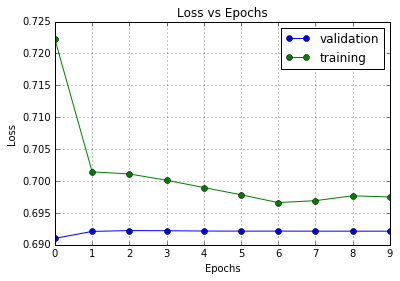

In [12]:
plt.plot(history.epoch,history.history['val_loss'],'-o',label='validation')
plt.plot(history.epoch,history.history['loss'],'-o',label='training')

plt.grid(True)
plt.legend(loc=0)

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss vs Epochs')

### Visualize - Learning Rate vs Epochs

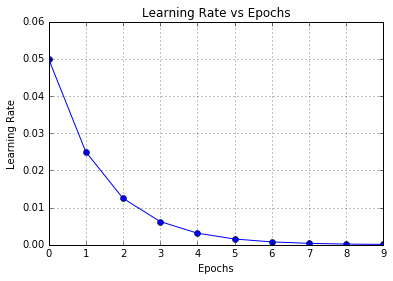

In [13]:
plt.plot(history.epoch, decay_rate,'-o')

plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')

In [14]:
for i in history.history:
    print(i)

loss
acc
val_loss
val_acc
